# Post Regression
In this notebook, we present a demo after training the neural network and obtaining the selection function. We first define some auxiliary functions to calculate the pseudo-power spectrum and mean target density.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft
from scipy.stats import binned_statistic



"""
        Some useful functions
    
"""
def make_hp(hpix, value, nside):
    """ A Function to create a HEALPix map
    """
    m_ = np.zeros(12*nside*nside)
    m_[:] = np.nan
    m_[hpix] = value
    
    return m_

def run_anafast(density, mask):
    """ A function to compute the angular pseudo-power spectrum
    """
    density_ = hp.ma(density)
    density_.mask = np.logical_not(mask)
    
    return hp.anafast(density_.filled())
    
def hist(ngal, frac, syst, bins, mask):
    """ A function to bin galaxy counts and 
    """
    ng,_,_ = binned_statistic(syst[mask], ngal[mask], statistic='sum', bins=bins)
    nr,_,_ = binned_statistic(syst[mask], frac[mask], statistic='sum', bins=bins)
    ns,_,_ = binned_statistic(syst[mask], syst[mask], statistic='mean', bins=bins)

    norm = ng.sum()/nr.sum()
    mean = ng/(nr*norm)

    return (ns, mean)

## Read Selection Function, Galaxy Density, Random Density, MASK

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Available columns: [('label', '>f8'), ('hpix', '>i8'), ('features', '>f8', (18,)), ('fracgood', '>f8')]


/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
<ipython-input-2-09b6cd9a642a>:19: RuntimeWarning: invalid value encountered in greater
  mask = mask > 0.5  # to make it binary
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


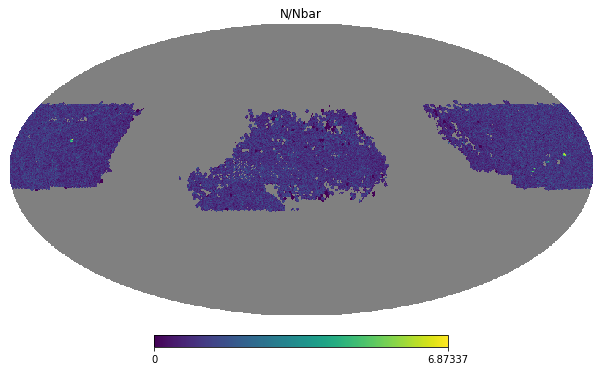

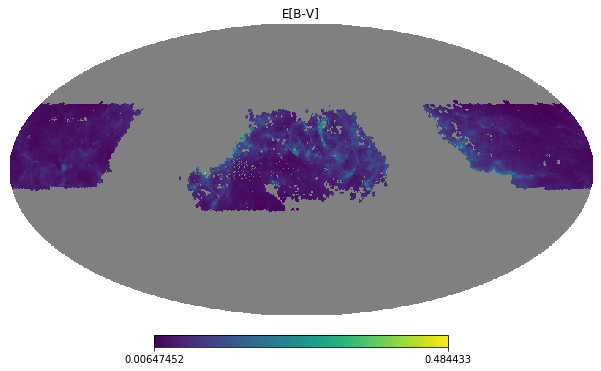

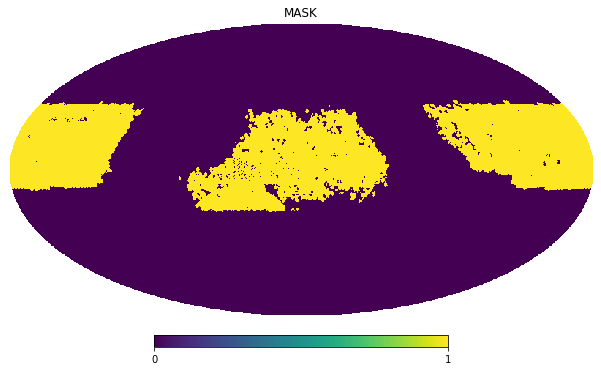

In [2]:
# read the selection function
npred = hp.read_map('../output/model_test/eBOSS.ELG.NGC.DR7.selection.fits')


# read data
nside = 256
data = ft.read('../input/eBOSS.ELG.NGC.DR7.table.fits')
print(f'Available columns: {data.dtype}')

# nnbar: galaxy count (normalized or not-normalized), 
# frac: pixel completeness
# ebv: one imaging property
# mask: a binary mask in healpix
nnbar = make_hp(data['hpix'], data['label'], nside)
frac  = make_hp(data['hpix'], data['fracgood'], nside)
ebv   = make_hp(data['hpix'], data['features'][:, 0], nside) # the 0th column is E[B-V]
mask = make_hp(data['hpix'], 1.0, nside)

mask = mask > 0.5  # to make it binary


# visualize some of these
hp.mollview(nnbar, title='N/Nbar')
hp.mollview(ebv, title='E[B-V]')
hp.mollview(mask, title='MASK')

## Mean Density vs E[B-V]

Text(0, 0.5, 'Mean Density')

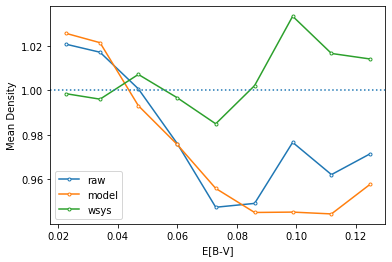

In [3]:
# determine the bins from the 2.5th and 97.5th quantiles of E[B-V]
bins = np.linspace(*np.percentile(ebv[mask], [2.5, 97.5]), 10) 

# compute mean density
nnbars = {}
nnbars['raw'] = hist(nnbar, frac, ebv, bins, mask)
nnbars['model'] = hist(npred*frac, frac, ebv, bins, mask)
nnbars['wsys'] = hist(nnbar/npred, frac, ebv, bins, mask)

# make a plot for mean density vs E[B-V]
for n_, nb_ in nnbars.items():
    plt.plot(*nb_, marker='.', mfc='w', label=n_)
    
plt.axhline(1.0, ls=':')
plt.legend()
plt.xlabel('E[B-V]')
plt.ylabel('Mean Density')

## Angular Power Spectrum

The mean density contrast $\delta$ can be defined in terms of the normalized mean density,
$$ \delta \equiv N/Nbar - 1$$

In [4]:
# get the density contrast from mean density
delta_raw = nnbar - 1.0
delta_wsys = nnbar/npred - 1.0

# compute pseudo-power spectrum
cl = {}
cl['raw'] = run_anafast(delta_raw, mask)
cl['wsys'] = run_anafast(delta_wsys, mask)

(1e-07, 0.001)

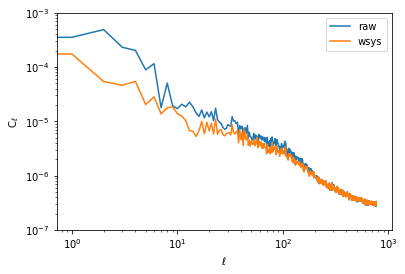

In [5]:
# plot pseudo-power vs ell
for n_, c_ in cl.items():
    plt.loglog(c_, label=n_)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.ylim(1.0e-7, 1.0e-3)

# Masking out high extinction regions

In [6]:
mask_new = mask & (ebv < 0.07)
mask_new.sum()/mask.sum()

<ipython-input-6-d3dd9d9be664>:1: RuntimeWarning: invalid value encountered in less
  mask_new = mask & (ebv < 0.07)


0.8170909498710328

In [7]:
cl['raw-masked'] = run_anafast(delta_raw, mask_new)
cl['wsys-masked'] = run_anafast(delta_wsys, mask_new)

(1e-07, 0.0006)

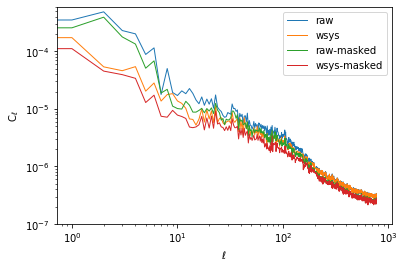

In [9]:
# plot pseudo-power vs ell
for n_, c_ in cl.items():
    plt.plot(c_, label=n_, lw=1)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.ylim(1.0e-7, 6.0e-4)